In [10]:
import os
import sys
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# === CHEMINS (A ADAPTER SI BESOIN) ===
BASE_DIR = os.getcwd()

# Dossiers de données
IMAGES_DIR = os.path.join(BASE_DIR, "data", "dataset_continuous_lesions", "image")
MASKS_DIR = os.path.join(BASE_DIR, "data", "dataset_continuous_lesions", "mask")

# Dossiers Code et Poids
SEGDINO_REPO = os.path.join(BASE_DIR, "SegDINO")
DINOV3_REPO = os.path.join(BASE_DIR, "dinov3")
# Attention: Vérifie bien le nom exact du fichier .pth
WEIGHTS_PATH = os.path.join(BASE_DIR, "weights", "dinov3_vits16_pretrain_lvd1689m-08c60483.pth")

# Dossier de sortie
RESULTS_DIR = os.path.join(BASE_DIR, "results_3d")
os.makedirs(RESULTS_DIR, exist_ok=True)

# === HYPERPARAMÈTRES ===
#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
BATCH_SIZE = 1  # Obligatoire à 1 pour le volumique (profondeurs variables)
EPOCHS = 20
LR = 2e-4
IMG_SIZE = 224

print(f"✅ Configuration chargée. Device: {DEVICE}")
print(f"📂 Résultats: {RESULTS_DIR}")

# Ajout des repos au path
if SEGDINO_REPO not in sys.path: sys.path.append(SEGDINO_REPO)
if DINOV3_REPO not in sys.path: sys.path.append(DINOV3_REPO)

✅ Configuration chargée. Device: cpu
📂 Résultats: /home/ulysse/Bureau/CD LAB/IRM/WORK/results_3d


In [11]:
class PatientVolumetricDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.volume_groups = {}
        all_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
        # --- PARSING DU NOMMAGE ---
        # Format attendu: Patient_Axe_SliceGlobale_SeqID_SeqPos.png
        for f in all_files:
            try:
                # On retire l'extension .png pour le split
                parts = f.replace('.png', '').split('_')
                if len(parts) >= 5:
                    # Clé unique = Patient + Axe + SeqID
                    # parts[0]: sub-strokecaseXXX
                    # parts[1]: axial/coronal/sagittal
                    # parts[3]: seqXX
                    unique_group_key = f"{parts[0]}_{parts[1]}_{parts[3]}"
                    
                    if unique_group_key not in self.volume_groups:
                        self.volume_groups[unique_group_key] = []
                    self.volume_groups[unique_group_key].append(f)
            except Exception as e:
                pass # Fichier mal nommé ignoré
                
        self.group_ids = list(self.volume_groups.keys())
        print(f"✅ Dataset: {len(self.group_ids)} séquences volumiques trouvées.")

    def __len__(self):
        return len(self.group_ids)

    def __getitem__(self, idx):
        group_key = self.group_ids[idx]
        files = self.volume_groups[group_key]
        
        # TRI IMPORTANT : On trie par le numéro de position dans la séquence (le dernier chiffre)
        # Ex: ..._01.png, ..._02.png
        files.sort(key=lambda x: int(x.replace('.png', '').split('_')[-1]))
        
        imgs = []
        masks = []
        
        for f_name in files:
            img_path = os.path.join(self.img_dir, f_name)
            mask_path = os.path.join(self.mask_dir, f_name)
            
            # Image
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            imgs.append(img)
            
            # Masque
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
            mask_np = np.array(mask)
            # Masque binaire (0 ou 1)
            mask_tensor = torch.from_numpy(mask_np > 0).float().unsqueeze(0)
            masks.append(mask_tensor)
        
        # Stack pour créer le volume (Depth, C, H, W)
        volume_img = torch.stack(imgs, dim=0)
        volume_mask = torch.stack(masks, dim=0)
        
        return volume_img, volume_mask

# Transformations DINO standards
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instanciation et Split
full_ds = PatientVolumetricDataset(IMAGES_DIR, MASKS_DIR, transform=img_transforms)
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

✅ Dataset: 687 séquences volumiques trouvées.


In [12]:
# Import de la classe officielle SegDINO
try:
    from dpt import DPT
    print("✅ Classe DPT (SegDINO) importée.")
except ImportError:
    raise ImportError("Impossible d'importer dpt.py. Vérifiez le chemin SEGDINO_REPO.")

# Chargement du Backbone DINOv3 (Local)
print("🏗️ Chargement du backbone...")
try:
    backbone = torch.hub.load(
        repo_or_dir=DINOV3_REPO, 
        model='dinov3_vits16',  # Version Small
        source='local', 
        weights=WEIGHTS_PATH
    )
    print("✅ Backbone chargé.")
except Exception as e:
    raise RuntimeError(f"Erreur chargement DINOv3: {e}")

# Instanciation du modèle SegDINO de base (2D) pour récupérer ses composants
base_model_2d = DPT(nclass=1, backbone=backbone).to(DEVICE)
print("✅ Modèle de base 2D initialisé (pour extraction des composants).")

✅ Classe DPT (SegDINO) importée.
🏗️ Chargement du backbone...
✅ Backbone chargé.
✅ Modèle de base 2D initialisé (pour extraction des composants).


In [20]:
class SegDINO3D(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = base_model.backbone
        self.head = base_model.head
        self.encoder_size = base_model.encoder_size
        self.intermediate_layer_idx = base_model.intermediate_layer_idx
        
        # Paramètres dimensionnels (ViT Small = 384)
        self.embed_dim = self.backbone.embed_dim 
        self.total_dim = self.embed_dim * 4 # 1536
        
        # --- MODULE DE FUSION 3D ---
        self.mixer_3d = nn.Sequential(
            nn.Conv3d(self.total_dim, self.total_dim, kernel_size=(3, 1, 1), padding=(1, 0, 0), groups=self.total_dim),
            nn.InstanceNorm3d(self.total_dim),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(self.total_dim, self.total_dim, kernel_size=1),
            nn.InstanceNorm3d(self.total_dim),
            nn.ReLU(inplace=True)
        )
        
        nn.init.zeros_(self.mixer_3d[-3].weight)
        nn.init.zeros_(self.mixer_3d[-3].bias)

        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x_volume):
        # Input: (Batch=1, Depth, 3, H, W)
        b, depth, c, h, w = x_volume.shape
        
        # 1. Extraction Features 2D
        x_flat = x_volume.view(b * depth, c, h, w)
        
        with torch.no_grad():
            features = self.backbone.get_intermediate_layers(
                x_flat, 
                n=self.intermediate_layer_idx[self.encoder_size]
            )
        
        # 2. Reconstitution des features multi-niveaux
        features_list = []
        patch_h, patch_w = h // 16, w // 16 
        num_tokens = patch_h * patch_w
        
        for feat in features:
            # feat: (TotalImages, N_tokens, Dim) -> (TotalImages, Dim, 14, 14)
            feat_spatial = feat[:, -num_tokens:, :] 
            feat_img = feat_spatial.permute(0, 2, 1).reshape(depth, self.embed_dim, patch_h, patch_w)
            features_list.append(feat_img)
            
        # Concaténation -> (Depth, 1536, 14, 14)
        concat_feat = torch.cat(features_list, dim=1)
        
        # 3. FUSION 3D
        # On passe en (Batch, Channels, Depth, H, W)
        # Avant: (1, Depth, Channels, H, W)
        # Après permute(0, 2, 1, 3, 4): (1, Channels, Depth, H, W) <--- CORRECTION ICI
        feat_3d_in = concat_feat.unsqueeze(0).permute(0, 2, 1, 3, 4)
        
        # Application du mélangeur 3D + Connexion résiduelle
        feat_3d_out = self.mixer_3d(feat_3d_in) + feat_3d_in
        
        # Retour au format pour le MLP (Depth, Channels, H, W)
        # (1, C, D, H, W) -> squeeze -> (C, D, H, W) -> permute -> (D, C, H, W)
        feat_2d_ready = feat_3d_out.squeeze(0).permute(1, 0, 2, 3)
        
        # 4. PRÉPARATION POUR LE DÉCODEUR OFFICIEL
        split_features = torch.chunk(feat_2d_ready, 4, dim=1)
        
        final_input_list = []
        for feat in split_features:
            feat_flat = feat.flatten(2).permute(0, 2, 1)
            final_input_list.append(feat_flat)
            
        # 5. Décodage Final (MLP)
        logits = self.head(final_input_list, patch_h, patch_w)
        
        mask = F.interpolate(logits, size=(h, w), mode='bilinear', align_corners=True)
        
        # Output: (1, Depth, 1, H, W)
        return mask.unsqueeze(0).permute(0, 1, 2, 3, 4)

# Instanciation
model = SegDINO3D(base_model_2d).to(DEVICE)
print("✅ Modèle 3D prêt (Dimension corrigée).")

✅ Modèle 3D prêt (Dimension corrigée).


In [21]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)
        inter = (inputs * targets).sum()
        dice = (2. * inter + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets):
        return 0.5 * self.bce(inputs, targets) + 0.5 * self.dice(inputs, targets)

def compute_metrics(logits, targets):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float().view(-1)
    targs = targets.view(-1)
    inter = (preds * targs).sum()
    union = preds.sum() + targs.sum()
    dice = (2. * inter + 1e-6) / (union + 1e-6)
    return dice.item()

criterion = CombinedLoss()
# On entraîne uniquement les parties non-gelées (Mixer 3D + Decoder)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scaler = GradScaler() # Pour économiser la mémoire GPU

/tmp/ipykernel_51602/1054588429.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Pour économiser la mémoire GPU


In [ ]:
history = {'train_loss': [], 'val_dice': []}
best_dice = 0.0

print(f"🚀 Démarrage Entraînement 3D (Batch=1, {EPOCHS} Epochs)...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    # --- TRAIN ---
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for vol_img, vol_mask in pbar:
        vol_img, vol_mask = vol_img.to(DEVICE), vol_mask.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Mixed Precision
        with autocast():
            outputs = model(vol_img)
            loss = criterion(outputs, vol_mask)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    avg_loss = epoch_loss / len(train_loader)
    
    # --- VALIDATION ---
    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for vol_img, vol_mask in val_loader:
            vol_img = vol_img.to(DEVICE)
            vol_mask = vol_mask.to(DEVICE)
            
            with autocast():
                outputs = model(vol_img)
            
            val_dice += compute_metrics(outputs, vol_mask)
            
    avg_dice = val_dice / len(val_loader)
    
    history['train_loss'].append(avg_loss)
    history['val_dice'].append(avg_dice)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val Dice: {avg_dice:.4f}")
    
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "best_segdino_3d.pth"))
        print("  💾 Nouveau meilleur modèle sauvegardé !")

print("🏁 Terminé.")

🚀 Démarrage Entraînement 3D (Batch=1, 20 Epochs)...


Epoch 1:   0%|                                          | 0/549 [00:00<?, ?it/s]/tmp/ipykernel_51602/2137659684.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|███████████████████| 549/549 [09:00<00:00,  1.02it/s, loss=0.5234]
/tmp/ipykernel_51602/2137659684.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 0.3426 | Val Dice: 0.5130
  💾 Nouveau meilleur modèle sauvegardé !


Epoch 2: 100%|███████████████████| 549/549 [10:29<00:00,  1.15s/it, loss=0.2153]


Epoch 2 | Loss: 0.2751 | Val Dice: 0.5389
  💾 Nouveau meilleur modèle sauvegardé !


Epoch 3: 100%|███████████████████| 549/549 [10:32<00:00,  1.15s/it, loss=0.1898]


Epoch 3 | Loss: 0.2505 | Val Dice: 0.5900
  💾 Nouveau meilleur modèle sauvegardé !


Epoch 4:  19%|███▋               | 105/549 [01:39<06:40,  1.11it/s, loss=0.5015]

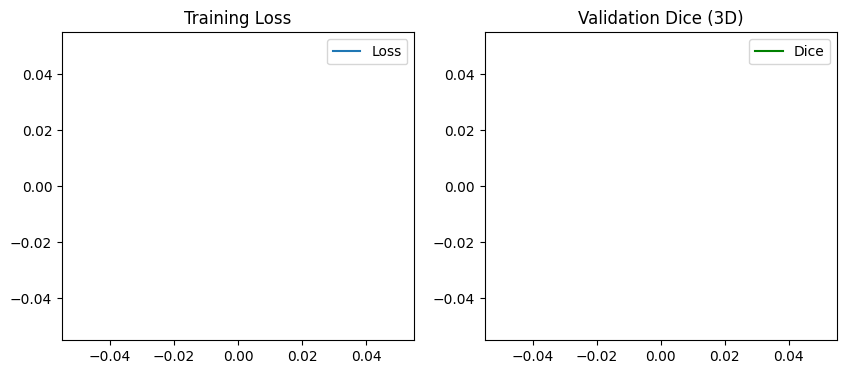

TypeError: DinoVisionTransformer.forward_features() got an unexpected keyword argument 'pixel_values'

In [16]:
# Courbes
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Loss')
plt.title("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['val_dice'], color='green', label='Dice')
plt.title("Validation Dice (3D)")
plt.legend()
plt.show()

# Exemple visuel
model.eval()
vol_img, vol_mask = next(iter(val_loader))
vol_img = vol_img.to(DEVICE)

with torch.no_grad():
    outputs = model(vol_img)
    preds = (torch.sigmoid(outputs) > 0.5).float().cpu()

# Afficher la slice du milieu
depth = vol_img.shape[1]
mid = depth // 2

img_show = vol_img[0, mid].cpu().permute(1, 2, 0).numpy()
# Normalisation pour affichage
img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

mask_show = vol_mask[0, mid, 0].cpu().numpy()
pred_show = preds[0, mid, 0].numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_show)
ax[0].set_title("Input (Slice Milieu)")
ax[1].imshow(mask_show, cmap='gray')
ax[1].set_title("Vérité")
ax[2].imshow(pred_show, cmap='gray')
ax[2].set_title("Prédiction 3D")
plt.show()